# Problema: Masa Resorte Amortiguador

In [ ]:
# Librerias utiles
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import imageio.v2 as imageio
from google.colab import drive
from google.colab import files
from os import TMP_MAX

# Modelo Físico

In [ ]:
# Parámetros físicos
l0 = 0.25 # m
g = 9.81  # m/s^2
m = 1     # kg
b = 0.5     # Ns/m
k = 2    # N/m
tiempo_total = 20 # s
delta_T = 0.01 # s
t_datos = 0.5*tiempo_total

In [ ]:
# Calculo de parámetros útiles
omega = np.sqrt(k/m)
seda  = b/(2*np.sqrt(m*k))
phi = np.arctan(-seda)
# Definir el vector de tiempo
t = np.arange(0, tiempo_total, delta_T)

print(f"omega = {omega}")
print(f"seda = {seda}")
print(f"phi = {phi}")


omega = 1.4142135623730951
seda = 0.17677669529663687
phi = -0.17496904566568885


In [ ]:
# Calcular desplazamiento y posición
def desplazamiento(tiempo):
  despl = (g / omega**2) * (1 - np.exp(-seda * omega * tiempo)* np.cos(omega * tiempo + phi)/np.cos(phi))
  return despl

u = desplazamiento(t)
x = u + l0


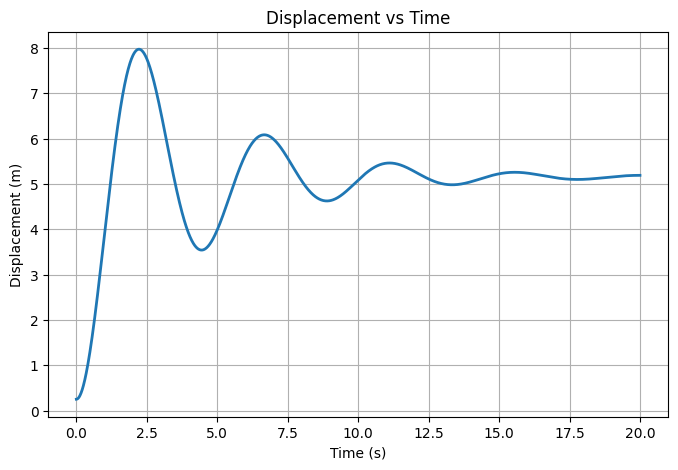

In [ ]:
# Graficar
plt.figure(figsize=(8, 5))
plt.plot(t, x, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.grid(True)
plt.title('Displacement vs Time')
plt.show()

# Parámetros para Modelos Predictivos

In [ ]:
# Crear datos de entrada para la red neuronal
# X es un vector de n valores seleccionados entre 0 y 10
n = 25 # Numero de muestras
t_datos =
t_max = t_datos # Tiempo maximo
t_min = 0 # Tiempo minimo
X = np.arange(t_min, t_max, (t_max-t_min)/n)
y = desplazamiento(X)
X_collocation = np.arange(0.0, tiempo_total, tiempo_total/100)
X_i = np.array([[0.0]])
b_init = np.array([[0.0]])

In [ ]:
# Convertir a tensores de PyTorch
X_train = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
X_test  = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
y_test  = torch.tensor(u, dtype=torch.float32).reshape(-1, 1)
X_train_phy = torch.tensor(X_collocation, dtype=torch.float32).reshape(-1, 1)
X_init = torch.tensor(X_i, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# Parametros de la Red Neuronal
epochs_FFNN =
epochs_PINN =
learning_rate =
nneurons =
nhiden_layers =
activation_fn = nn.Tanh()
make_video = False

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])

# Feed-Forward Neural Network (FFNN)

## Clase Deep Neural Network 🧠

In [ ]:
class DNN(nn.Module):

  # Inicialización de la RED
  def __init__(self, layers):
    super(DNN, self).__init__() # Llama __init__ de la clase padre

    # Funcion de activacion
    self.activation_fn = activation_fn

    # Historial de loss
    self.loss_history = []

    # Definir capas (crea una lista de capas Fully connected)
    self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    # Inicializacion de pesos Xavier Glorot y bias como ceros
    for i in range(len(layers)-1):
      # Pesos
      nn.init.xavier_normal_(self.layers[i].weight.data, gain=1.0)
      # Bias
      nn.init.zeros_(self.layers[i].bias.data)

  # Propagación hacia adelante
  def forward(self, x):
    for i in range(len(layers)-2):
      x = self.activation_fn(self.layers[i](x))

    x = self.layers[-1](x)
    return x

## Intanciar el modelo ⛏

In [ ]:
# Instanciar modelo, definir función de pérdida y optimizador
model_ffnn = DNN(layers)
loss_fn = nn.MSELoss(reduction = "mean")
optimizer = optim.Adam(model_ffnn.parameters(), lr=learning_rate)

## Entrenar 🦾

In [ ]:
# Entrenar el modelo

frames = [] # Lista para guardar imágenes

for epoch in range(epochs_FFNN):
  # Forward
  y_pred = model_ffnn(X_train)
  loss = loss_fn(y_pred, y_train)
  model_ffnn.loss_history.append(loss.item())

  # Backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch) % 10 == 0:
    print(f'Epoch [{epoch}/{epochs_FFNN}], Loss: {loss.item():.6f}')

    if make_video:
      # Haciendo plots para video
      y_pred = model_ffnn(X_test).detach().numpy()
      plt.figure(figsize=(8, 5))
      plt.plot(X_test[:, 0].numpy(), y_test.numpy(), label='Real', linewidth=1.5)
      plt.plot(X_test[:, 0].numpy(), y_pred, label='Predicho', linewidth=1.5, linestyle='dashed')
      # plot los puntos de evaluacion con X
      plt.scatter(X[:, 0], y, color='red', label='Puntos de evaluación', marker= 'x')
      plt.xlabel('Time (seda)')
      plt.ylabel('Displacement (m)')
      plt.legend()
      plt.title(f"Epoch {epoch}")
      plt.savefig(f"frame_{epoch}.png")
      plt.close()
      frames.append(imageio.imread(f"frame_{epoch}.png"))

if make_video:
  # Guardar el GIF
  gif_path = "/content/training_animation.gif"
  imageio.mimsave(gif_path, frames, duration=0.5)
  files.download(gif_path)

Epoch [0/10000], Loss: 27.836309
Epoch [10/10000], Loss: 20.018288
Epoch [20/10000], Loss: 13.972771
Epoch [30/10000], Loss: 9.531659
Epoch [40/10000], Loss: 6.428525
Epoch [50/10000], Loss: 4.381212
Epoch [60/10000], Loss: 3.139655
Epoch [70/10000], Loss: 2.469031
Epoch [80/10000], Loss: 2.153074
Epoch [90/10000], Loss: 2.021311
Epoch [100/10000], Loss: 1.965514
Epoch [110/10000], Loss: 1.932845
Epoch [120/10000], Loss: 1.905028
Epoch [130/10000], Loss: 1.878578
Epoch [140/10000], Loss: 1.853678
Epoch [150/10000], Loss: 1.830484
Epoch [160/10000], Loss: 1.808759
Epoch [170/10000], Loss: 1.788192
Epoch [180/10000], Loss: 1.768550
Epoch [190/10000], Loss: 1.749677
Epoch [200/10000], Loss: 1.731442
Epoch [210/10000], Loss: 1.713720
Epoch [220/10000], Loss: 1.696383
Epoch [230/10000], Loss: 1.679306
Epoch [240/10000], Loss: 1.662370
Epoch [250/10000], Loss: 1.645474
Epoch [260/10000], Loss: 1.628531
Epoch [270/10000], Loss: 1.611478
Epoch [280/10000], Loss: 1.594267
Epoch [290/10000], Los

## Evaluar resultados 📈

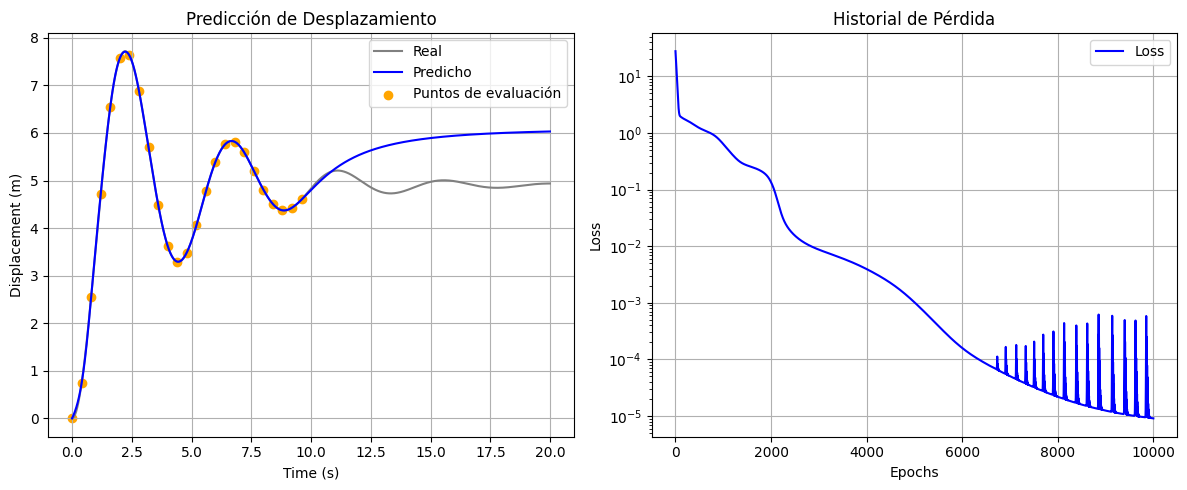

In [ ]:
# Hacer predicciones
model_ffnn.eval()
y_pred = model_ffnn(X_test).detach().numpy()

# Crear una figura con 2 subgráficos (1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Gráfico 1: Predicción vs Real ---
axs[0].plot(X_test[:, 0].numpy(), y_test.numpy(), label='Real', linewidth=1.5, color = 'grey')
axs[0].plot(X_test[:, 0].numpy(), y_pred, label='Predicho', linewidth=1.5, color = 'blue')
axs[0].scatter(X_train[:, 0], y_train, color='orange', label='Puntos de evaluación', marker='o')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Displacement (m)')
axs[0].grid(True)
axs[0].set_title('Predicción de Desplazamiento')
axs[0].legend()

# --- Gráfico 2: Historial de pérdida ---
axs[1].semilogy(model_ffnn.loss_history, label='Loss', color='blue', linewidth=1.5)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid(True)
axs[1].set_title('Historial de Pérdida')
axs[1].legend()

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()


# Modelo Predictivo - Physics-Informed Neural Network (PINN)

## Clase PINN ⚛

In [ ]:
class PINN():
  def __init__(self,layers):

    # funcion de perdida
    self.loss_fn = nn.MSELoss(reduction = "mean")

    # Inicializando iterador
    self.iter = 0

    # Inicializando la DNN
    self.dnn = DNN(layers)

    # Inicializando el historial de losses
    self.loss_history = {"Data":[],
                         "Physics":[],
                         "IC":[],
                         "Total":[],
                        }
  def loss_data(self, X, y):
    y_pred = self.dnn(X).reshape(-1,1)
    loss_data = self.loss_fn(y_pred, y)
    self.loss_history["Data"].append(loss_data.item())
    return loss_data

  def loss_physics(self, X_phy, X_init):
    # mg - k(x - l0) - b dx/dt - m ddx/ddt = 0
    # como la red toma X_phy (tiempo) y devuelve y_pred (desplazamiento)
    # Se tiene: x = y_pred + l0
    #           t = X_phy
    # Loss_phy = mg - k(y_pred) - b d(x)/d(X_phy) - m dd(x)/dd(X_phy)
    X_physics = X_phy.clone().requires_grad_(True)
    y_pred = self.dnn(X_physics).reshape(-1,1)
    u = y_pred

    # COMPLETAR ...
    du_dt = torch.autograd.grad(..., ..., torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    ddu_ddt = torch.autograd.grad(..., ..., torch.ones_like(du_dt), retain_graph=True, create_graph=True)[0]
    loss_physics = torch.norm( ... )
    # .............

    self.loss_history["Physics"].append(loss_physics.item())

    # En el instante inicial:
    # u(0) = 0
    # du/dt(0) = 0
    # ddu/ddt(0) = g(1-seda**2)
    X_initial = X_init.clone().requires_grad_(True)
    y_pred_init = self.dnn(X_initial).reshape(-1,1)
    u_init = y_pred_init

    # COMPLETAR ...
    du_dt_init = torch.autograd.grad(..., ..., torch.ones_like(u_init), retain_graph=True, create_graph=True)[0]
    ddu_ddt_init = torch.autograd.grad(..., ..., torch.ones_like(du_dt_init), retain_graph=True, create_graph=True)[0]
    loss_IC_term_1 = torch.norm( ... )
    loss_IC_term_2 = torch.norm( ... )
    loss_IC_term_3 = torch.norm( ... )
    # .............

    loss_IC = loss_IC_term_1 + loss_IC_term_2 + loss_IC_term_3
    self.loss_history["IC"].append(loss_IC.item())

    return loss_physics, loss_IC

  def loss_total(self, X, y, X_phy, X_init):
    loss_data = self.loss_data(X, y)
    loss_physics, loss_IC = self.loss_physics(X_phy, X_init)
    loss_total = loss_data + loss_physics + loss_IC
    self.loss_history["Total"].append(loss_total.item())
    return loss_total, loss_data, loss_physics, loss_IC



## Instanciar modelo ⛏

In [ ]:
# Instanciar modelo, definir función de pérdida y optimizador
model_pinn = PINN(layers)
loss_fn = nn.MSELoss(reduction = "mean")
optimizer = optim.Adam(model_pinn.dnn.parameters(), lr=learning_rate)

## Entrenar 🦾

In [ ]:
# Entrenamiento del modelo

print('Training with ADAM')
for epoch in range(epochs_PINN):
  # Forward
  loss, loss_data, loss_physics, loss_IC = model_pinn.loss_total(X_train, y_train, X_train_phy, X_init)

  # Backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch) % 100 == 0:
    print(f'Epoch [{epoch}/{epochs_PINN}], Loss_T: {loss.item():.6f}, Loss_data: {loss_data.item():.6f}, Loss_physics: {loss_physics.item():.6f}, Loss_IC: {loss_IC.item():.6f}')

    if make_video:
      # Haciendo plots para video
      y_pred = model_pinn(X_test).detach().numpy()
      plt.figure(figsize=(8, 5))
      plt.plot(X_test[:, 0].numpy(), y_test.numpy(), label='Real', linewidth=1.5)
      plt.plot(X_test[:, 0].numpy(), y_pred, label='Predicho', linewidth=1.5, linestyle='dashed')
      # plot los puntos de evaluacion con X
      plt.scatter(X[:, 0], y, color='red', label='Puntos de evaluación', marker= 'x')
      plt.xlabel('Time (seda)')
      plt.ylabel('Displacement (m)')
      plt.legend()
      plt.title(f"Epoch {epoch}")
      plt.savefig(f"frame_{epoch}.png")
      plt.close()
      frames.append(imageio.imread(f"frame_{epoch}.png"))

if make_video:
  # Guardar el GIF
  gif_path = "/content/training_animation.gif"
  imageio.mimsave(gif_path, frames, duration=0.5)
  files.download(gif_path)


Training with ADAM
Epoch [0/50000], Loss_T: 132.598038, Loss_data: 24.405342, Loss_physics: 98.600288, Loss_IC: 9.592410
Epoch [100/50000], Loss_T: 27.837849, Loss_data: 1.984062, Loss_physics: 11.108879, Loss_IC: 14.744907
Epoch [200/50000], Loss_T: 18.527714, Loss_data: 3.061105, Loss_physics: 0.680918, Loss_IC: 14.785690
Epoch [300/50000], Loss_T: 18.759960, Loss_data: 3.127120, Loss_physics: 1.075562, Loss_IC: 14.557279
Epoch [400/50000], Loss_T: 17.848175, Loss_data: 3.153827, Loss_physics: 0.134926, Loss_IC: 14.559422
Epoch [500/50000], Loss_T: 17.986721, Loss_data: 3.151377, Loss_physics: 0.322442, Loss_IC: 14.512902
Epoch [600/50000], Loss_T: 17.985579, Loss_data: 3.153132, Loss_physics: 0.339450, Loss_IC: 14.492996
Epoch [700/50000], Loss_T: 17.916710, Loss_data: 3.155182, Loss_physics: 0.280242, Loss_IC: 14.481287
Epoch [800/50000], Loss_T: 17.927519, Loss_data: 3.155683, Loss_physics: 0.302866, Loss_IC: 14.468969
Epoch [900/50000], Loss_T: 17.865059, Loss_data: 3.157166, Los

## Evaluar resultados 📈

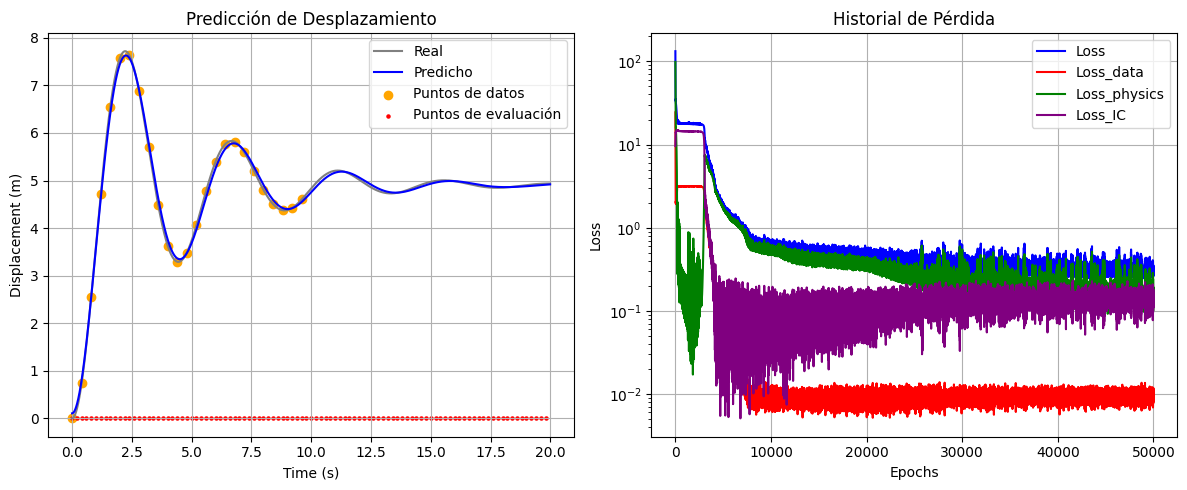

In [ ]:
# Hacer predicciones
y_pred = model_pinn.dnn(X_test).detach().numpy()

# Crear una figura con 2 subgráficos (1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Gráfico 1: Predicción vs Real ---
axs[0].plot(X_test[:, 0].numpy(), y_test.numpy(), label='Real', linewidth=1.5, color = 'grey')
axs[0].plot(X_test[:, 0].numpy(), y_pred, label='Predicho', linewidth=1.5, color = 'blue')
axs[0].scatter(X_train[:, 0], y_train, color='orange', label='Puntos de datos', marker='o')
axs[0].scatter(X_collocation, np.zeros_like(X_collocation), color='red', label='Puntos de evaluación', marker= 'o', s=5)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Displacement (m)')
axs[0].grid(True)
axs[0].set_title('Predicción de Desplazamiento')
axs[0].legend()

# --- Gráfico 2: Historial de pérdida ---
# plot y logaritmico
axs[1].semilogy(model_pinn.loss_history["Total"], label='Loss', color='blue', linewidth=1.5)
axs[1].semilogy(model_pinn.loss_history["Data"], label='Loss_data', color='red', linewidth=1.5)
axs[1].semilogy(model_pinn.loss_history["Physics"], label='Loss_physics', color='green', linewidth=1.5)
axs[1].semilogy(model_pinn.loss_history["IC"], label='Loss_IC', color='purple', linewidth=1.5)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid(True)
axs[1].set_title('Historial de Pérdida')
axs[1].legend()

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()